In [1]:
import os
from os.path import basename, dirname, join, exists
import sys
import time

import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
import geopandas as gpd

# 1d so the smoothing is specific to each realization
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines

import h5py


In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Box/research_cosumnes/GWFlowModel')

flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
import flopy 
import flopy.utils.binaryfile as bf


In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning'
tprogs_id = '_no_cond_c3d'


data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [4]:
nrow = 100
ncol = 230

In [5]:
setbacks = np.arange(0, 3400,200)
# smoothed XS data used for setback analysis
xs_levee_smooth = pd.read_csv(chan_dir+'xs_levee_smooth.csv', index_col='dist_from_right_m')
num_segs = xs_levee_smooth.shape[1]

# load array identifying row,col to XS id (1,28)
xs_arr = np.loadtxt(chan_dir+'XS_num_grid_reference.tsv')

# load flood typology characteristics (based on daily data 1908 - 2014) - median values 
#"cms_pk" for peak discharge, "pk_loc" for time to peak, and "log_no_d" for duration
flood_type = pd.read_csv(join(box_dir, 'whipple_grp6_w97ftmedians.csv'),index_col='Group.1')


In [6]:
import h5py
f = h5py.File(join(chan_dir, 'setback_locs.hdf5'), "r")
local_str_setbacks = f['setbacks']['local'][:]
str_setbacks = f['setbacks']['regional'][:]

f.close()

In [7]:

def load_hdf5_output(ft_in, region):
    tic = time.time()
    T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
    p_l_in = flood_type.loc[ft_in,'pk_loc']
    tp_in = int(p_l_in*T_in)
    rch_hf_all = np.zeros((100, len(setbacks),nrow,ncol))
    Q_all = np.zeros((100, T_in, len(setbacks),xs_levee_smooth.shape[1]+1))
    d_xs_all = np.zeros((100, T_in, len(setbacks),xs_levee_smooth.shape[1]+1))
    d_all = np.zeros((100, T_in, len(setbacks),xs_levee_smooth.shape[1]))
    d_arr_all = np.zeros((100, len(setbacks),nrow,ncol))
    cell_frac_all = np.zeros((100, len(setbacks),nrow,ncol))

    # filter out for only those realizations that successfully ran
    base_fn = join(data_dir, region, 'type'+str(ft_in))
    r_out = pd.Series(os.listdir(base_fn)).str.extract(r'(\d{3})')[0].unique().astype(int)
    # takes a 
    for t in r_out: # np.arange(0,100): #[0]:
        # load hdf5 files for each realization
        r_fn = join(base_fn,'r'+str(t).zfill(3)+'_')
        f = h5py.File(r_fn+'output.hdf5', "r")
        Q = f['array']['flow'][:]        
        rch_hf = f['array']['rch_hf'][:]
        # depth is a little complicated to summarize, not so bad to back it out from
        d_arr = f['array']['depth'][:]
        d_xs = f['array']['XS_depth'][:]
        cell_frac = f['array']['cell_frac'][:]
        f.close()
        # saving all of the flow at all steps, setbacks is needed to post-process
        Q_all[t] = np.copy(Q)
        # saving XS depth at all steps, setbacks needed to post-process
        d_xs_all[t] = np.copy(d_xs)
        # sum recharge across time to save storage space (breaks python at 25GB)
        rch_hf = np.nansum(rch_hf, axis=0)
        rch_hf_all[t] = np.copy(rch_hf)
        # cell_frac - frational cell inundated should follow same pattern as depth array
        cell_frac_all[t] = np.nanmean(ma.masked_where(cell_frac==0, cell_frac), axis=0)        
        # average depth across time to save storage space (breaks python at 25GB)
        d_arr_all[t] = np.nanmean(ma.masked_where(d_arr==0, d_arr), axis=0)
        # depth needs to be averaged across each segment to keep for all times
        for s in np.arange(0,len(setbacks)):
            for nseg in np.arange(0, num_segs):
                # mask zeros to not estimate depth based on zero values
                # could present as average positive depth or maximum
                d_out = d_arr[:,s, (xs_arr==nseg)&(str_setbacks[s].astype(bool))]
                d_all[t,:,s, nseg] =  ma.masked_where(d_out==0, d_out).mean()


    # convert to m3/day and will have the total recharged after summing individual days
    rch_hf_all = rch_hf_all*86400

    toc = time.time()
    print('Loading',region,'for flow type',str(ft_in), 'took %.2f minutes' %((toc-tic)/60))
    return(Q_all, rch_hf_all, d_all, d_arr_all, cell_frac_all, d_xs_all)

In [8]:
# ft_in=1
# region='regional'
# Q_all, rch_hf_all, d_all, d_arr_all = load_hdf5_output(ft_in, region)


In [ ]:
ft_in=1

T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
p_l_in = flood_type.loc[ft_in,'pk_loc']
tp_in = int(p_l_in*T_in)

In [ ]:
# d_seg = np.zeros((100, T_in, len(setbacks),xs_levee_smooth.shape[1]))

# tic = time.time()

# # takes .045 sec to extract nseg, should take about 5 sec
# for t in np.arange(0,100):
#     for s in np.arange(0,len(setbacks)):
#         for nseg in np.arange(0, num_segs):
#             # mask zeros to not estimate depth based on zero values
#             d_out = d_all[t,:,s, (xs_arr==nseg)&(str_setbacks[s].astype(bool))]
#             d_seg[t,:,s, nseg] =  ma.masked_where(d_out==0, d_out).mean()
# toc = time.time()
# toc-tic

## Save files as hdf5 to save time with reloading
For each region and flow type save an hdf5 file that will include all realizations, so when reloading it takes 1 second instead of minutes.

In [ ]:
# ends up as about 500 MB, may want individual files

def arr_to_h5(arr, h5_fn):
    # convert arrays of annual etc to hdf5 files individually
    f = h5py.File(h5_fn, "w")
    grp = f.require_group('array') # makes sure group exists
    grp.attrs['units'] = 'cubic meters per day'
    grp.attrs['description'] = 'Each layer of the array is a day in the triangular hydrograph'
    dset = grp.require_dataset('all', arr.shape, dtype='f', compression="gzip", compression_opts=4)
    dset[:] = arr
    f.close()


This code only needs to be re-run when the models are rerun.

In [9]:
# recreate_hdf5 = True
recreate_hdf5 = False

In [ ]:
if recreate_hdf5:
    for region in ['regional']: #['local_1','local_2','local_3']: # 'regional'
        for ft_in in [1,2,3]:
            print(ft_in)
#             Q_all, rch_hf_all = load_output(ft_in, region)
            Q_all, rch_hf_all, d_all, d_arr_all, cell_frac, d_xs_all = load_hdf5_output(ft_in, region)

            arr_to_h5(Q_all, join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'))
            arr_to_h5(rch_hf_all, join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'))
            arr_to_h5(d_all, join(data_dir,'hdf5', 'all_depth_'+region+'_type'+str(ft_in)+'.hdf5'))
            arr_to_h5(d_arr_all, join(data_dir,'hdf5', 'depth_avg_arr'+region+'_type'+str(ft_in)+'.hdf5'))
            arr_to_h5(cell_frac, join(data_dir,'hdf5', 'cell_frac_arr'+region+'_type'+str(ft_in)+'.hdf5'))
            arr_to_h5(d_xs_all, join(data_dir,'hdf5', 'peak_flow_xs_depth_'+region+'_type'+str(ft_in)+'.hdf5'))

else:
    print('Reusing existing recharge and flow hdf5 files')

In [10]:
ft_plt = [1,2,3]


# Check fo setback distances/realizations that violate the minimum in-stream flow

In [11]:
region='regional'
ft_in=2
f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
Q_all = f['array']['all'][:]
f.close()


In [12]:
# minimum in-stream flow is 180 cfs generally, it is slightly higher as one goes up stream as it is dependent
# on depth (1 foot for adults, 6 inches for juveniles)
min_flw = 180*(0.3048**3)
# find if the output discharge violates the minimum flow at any day in a flow event
# for segments if any segment is violated then there is an issue
# might need to consider the number of segments and days that are an issue
# report by realization and setback distance
min_flw_df = pd.DataFrame(np.transpose(np.where(Q_all < min_flw)), columns=['r','day','setback','seg'])

array([[<Axes: title={'center': 'setback'}>]], dtype=object)

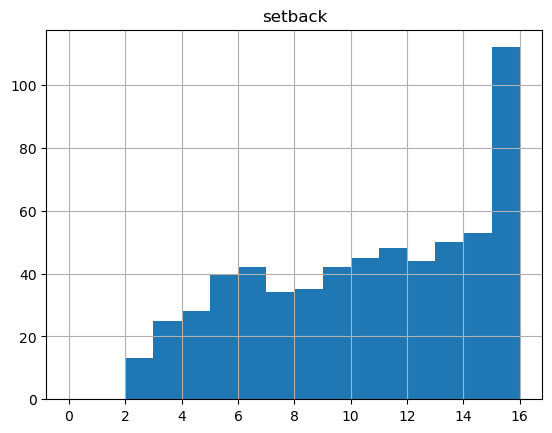

In [13]:
# find realizations and setbacks that have any days or segments below the threshold
any_min_flw = min_flw_df[['r','setback']].drop_duplicates()
# find range of setbacks that generally cause excess flow loss
# any_min_flw.hist('r', bins=range(100))
any_min_flw.hist('setback', bins=range(17))

The histogram of realizations that break the minimum flow threshold per setback is helpful to visualize because it shows that by the 8th setback (1600 m) that 30-40% of the time the minimum flow threshold is broken.

In [14]:
# if we want to get particular we could count the number of days a segment fails and allow for 1 or 2 perhaps?
# but there wouldn't be validation for it except perhaps that research like Kenny's show salmon can survive
# in disconnected pulls for a certain period
# min_flw_df.groupby(['r','setback','seg']).count()

In [15]:
# was using regional and ft_in=2 (large and long) for example plots
region = 'regional'
ft_in = 2

f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
rch_hf_all = f['array']['all'][:]
f.close()

In [16]:
rch_hf_all.shape
# if the in-stream flow becomes zero then remove any recharge from that realization to represent it as a null case
# as it would not be implemented
rch_hf_all_adj = np.copy(rch_hf_all)
rch_hf_all_adj[min_flw_df.r, min_flw_df.setback] = np.nan

In [17]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

stats_elements = [
    Line2D([0], [0],color='grey',label='Individual\nRealization'),
#     Line2D([0], [0],color='black',label='5th/95th', linestyle='--'),
    Line2D([0], [0],color='black',label='1.5x Quartile\nRange'),
    Line2D([0], [0],color='tab:blue',label='25th/75th'),
    Line2D([0], [0],color='tab:green',label='Median'),
]


The box extends from the first quartile (Q1) to the third quartile (Q3) of the data, with a line at the median. 
The whiskers extend from the box by 1.5x the inter-quartile range (IQR)  
whis = 1.5
IQR = Q3-Q1
upper whisker =  Q3 + whis\*IQR
lower whisker = Q1 - whis\*IQR


# Recharge by setback distance

If we know that the geology has a consistent relationship with recharge then we can trust an example realization like the median because we know that the recharge will shift in a certain way given a change in geology (e.g., HCP area).

In [18]:
# rch_xs_sum = pd.DataFrame(np.sum(rch_hf_all, axis=(2,3)), columns= setbacks).transpose()/1E6
# rch_xs_sum.multiply(1/rch_xs_sum.loc[0])

In [19]:
rch_col = int(230/3) # lower third
# while there is slightly more flooding in the lower 2/3 the setback distance still suggests 200 m more than 600/1200
# rch_col = int(230*2/3) # lower 2/3

np.unique(xs_arr[:, :rch_col]),np.unique(xs_arr[:, :rch_col]).shape
# there are 9 xs in the lower third which is 1/3 of XS as well, so it makes it easy to compare both ways 

(array([19., 20., 21., 22., 23., 24., 25., 26., 27., nan]), (10,))

In [61]:
region='regional'
rch_xs_all = pd.DataFrame()
rch_chan_all = pd.DataFrame()
# subset results to lower region with most recharge activity and shallowest water tables
rch_lower = pd.DataFrame()

for nf, ft_in in enumerate(ft_plt):
    with h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r") as f:
        rch_hf_all = f['array']['all'][:]
    # aggregate to XS level
    rch_xs_sum = pd.DataFrame(np.sum(rch_hf_all, axis=(2,3)), columns= setbacks).transpose()/1E6
    rch_xs_all = pd.concat((rch_xs_all, rch_xs_sum.assign(ft = ft_in)))
    # calculate the recharge specific to the channel for each setback
    rch_chan_sum = pd.DataFrame(rch_hf_all[:,:, str_setbacks[0]==1].sum(axis=2), columns= setbacks).transpose()/1E6
    rch_chan_all = pd.concat((rch_chan_all, rch_chan_sum.assign(ft = ft_in)))
    # pull recharge results for the domain bottom 1/3
    rch_lower_sum = pd.DataFrame(np.sum(rch_hf_all[:,:,:, :rch_col], axis=(2,3)), columns= setbacks).transpose()/1E6
    rch_lower = pd.concat((rch_lower, rch_lower_sum.assign(ft = ft_in)))
        

In [32]:
setback_area = str_setbacks[:,:,:rch_col].sum(axis=(1,2))*200*200


def plt_rech(rch_xs_all, setback_area=None):
    rch_sum = pd.DataFrame()
    fig,ax=plt.subplots(3, 1, sharex='col', sharey=False, figsize=(6.5,7), dpi=300)
    for nf, ft_in in enumerate(ft_plt):
        # second plot for boxplot
        ax_n = ax[nf]    
        rch_xs_sum = rch_xs_all.loc[rch_xs_all.ft==ft_in].drop(columns=['ft'])
        if setback_area is not None:
            rch_xs_sum = rch_xs_sum.multiply(1E6/setback_area, axis=0)

        rch_xs_sum.transpose().boxplot(ax=ax_n)
        rch_sum = pd.concat((rch_sum, rch_xs_sum.assign(ft=ft_in)))
        # print(rch_xs_sum.median(axis=1).loc[0:1200])
    for nf, ft_in in enumerate(ft_plt):
        ax_n = ax[nf]
        ax_n.annotate('Type '+str(ft_in),xy=(0.025,0.8),xycoords='axes fraction')
    
    # set x labels for boxplots 
    ax_n = ax[-1]
    rot_ticks =  plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    fig.supylabel('Total Recharge (MCM)')#, x=-0.01)
    fig.supxlabel('Setback Distance (m)')#,y=-0.04)
    
    fig.tight_layout()
    return rch_sum
    # fig.savefig(join(fig_dir, 'all_recharge.png'), bbox_inches='tight')


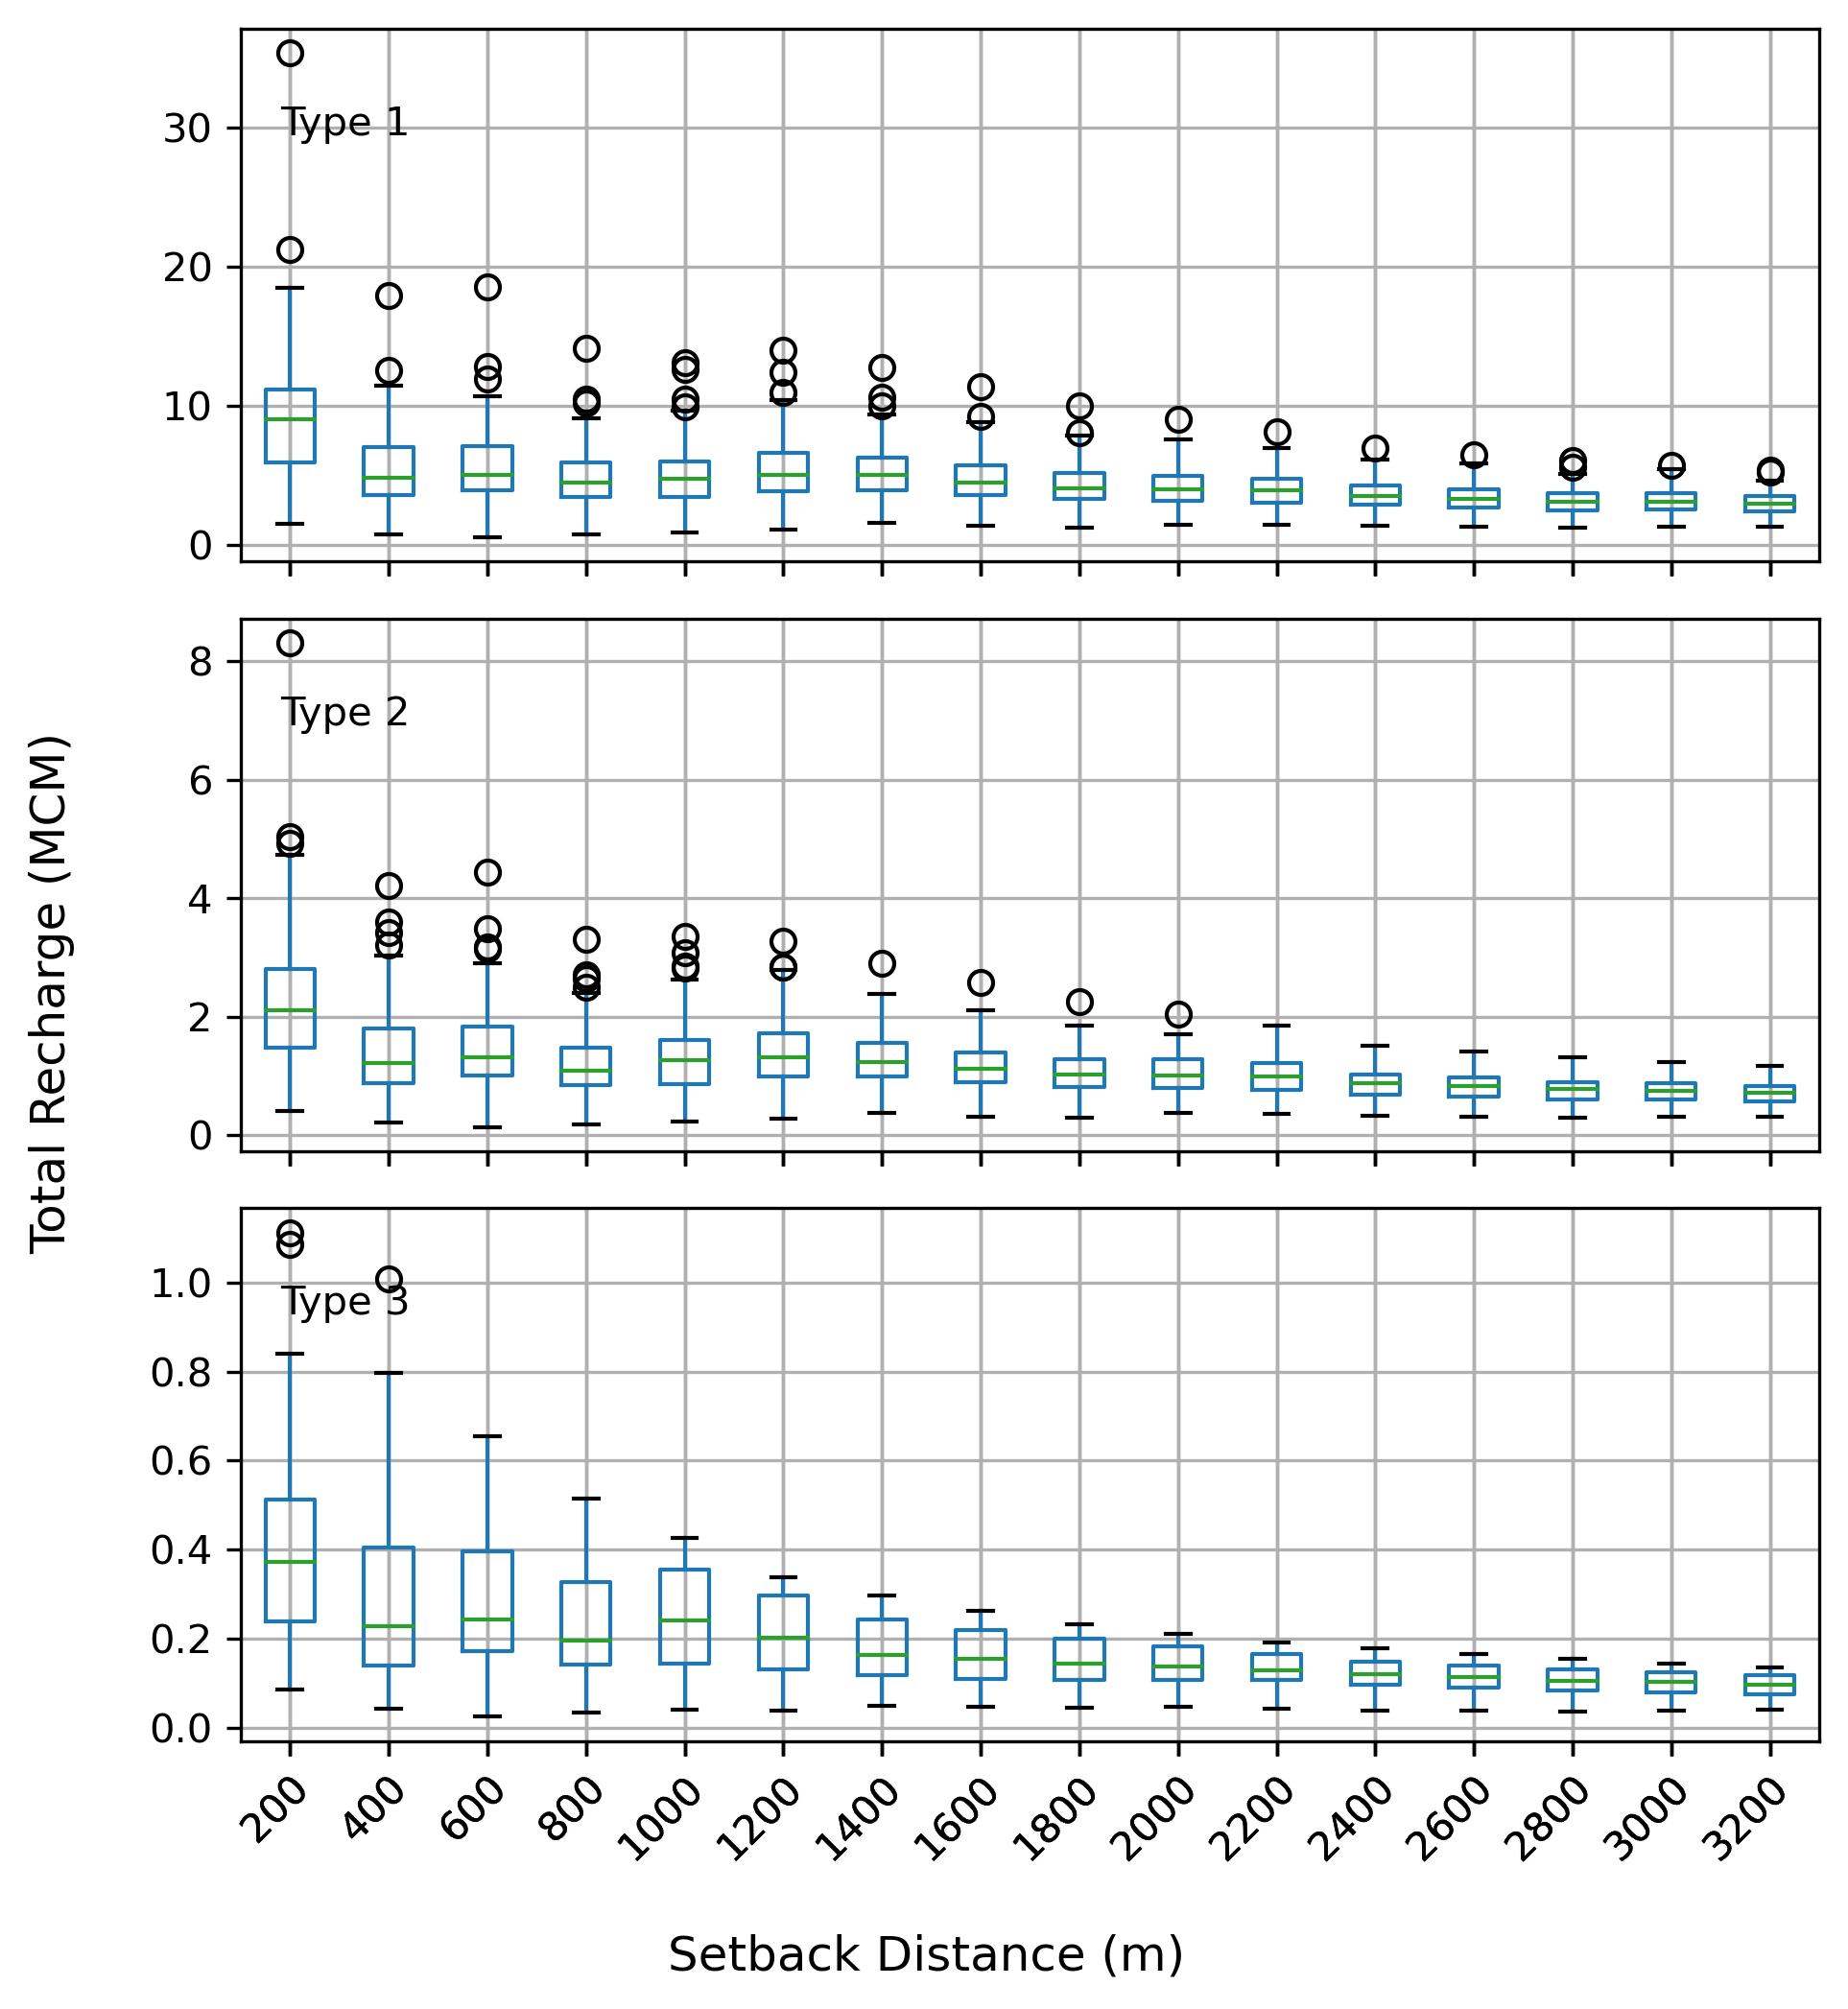

In [45]:
# compare the cumulative recharge to the area it covers
setback_area = str_setbacks.sum(axis=(1,2))*200*200
rch_sum = plt_rech(rch_xs_all.loc[setbacks[1:]], setback_area[1:])

In [37]:
# rch_sum_lower = plt_rech(rch_lower)

In [22]:
# ft_in=2
# rch_xs_all.loc[rch_xs_all.ft==ft_in].drop(columns=['ft']).loc[1200].median()


In [23]:
rch_xs_all.drop(columns=['ft']).loc[600].median(axis=1).values/rch_xs_all.drop(columns=['ft']).loc[1200].median(axis=1).values

array([0.51720196, 0.5173366 , 0.61684346], dtype=float32)

In [26]:
# def scale_rch(rch_xs_all):
#     ## plot the recharge values summed together to give a representative year given the probability of occuring
#     scale = [0.15, .36, .53]
#     rch_scale = pd.DataFrame()

#     for nf, ft_in in enumerate(ft_plt):
#             rch_scale = pd.concat((rch_scale, rch_xs_all.loc[rch_xs_all.ft==ft_in] * scale[nf]))

#     # aggregate
#     rch_scale = rch_scale.groupby(rch_scale.index).sum()
#     return(rch_scale)
# rch_scale = scale_rch(rch_xs_all)
# rch_scale_lower = scale_rch(rch_lower)

In [ ]:
# # compare the cumulative recharge to the area it covers
# setback_area = str_setbacks.sum(axis=(1,2))*200*200
# eff_rch = rch_scale.multiply(1E6/setback_area, axis=0)
# # just for lower area
# setback_area = str_setbacks[:,:,:rch_col].sum(axis=(1,2))*200*200
# eff_rch_lower = rch_scale_lower.multiply(1E6/setback_area, axis=0)


In [ ]:
# rch_scale.median(axis=1).loc[[600,1200]]

In [ ]:
# eff_rch.median(axis=1).loc[400:].plot()
# eff_rch_lower.median(axis=1).loc[200:].plot()

In [ ]:
# def scale_eff_plt(rch_scale, eff_rch):
#     fig, ax = plt.subplots(2,1,figsize=(6.5,4), dpi=300, sharex=True)

#     ax_n = ax[0]
#     rch_scale.transpose().boxplot(ax=ax_n, rot=45)
#     ax_n.set_ylabel('Expected\nRecharge (MCM)')#, x=-0.01)

#     ax_n = ax[1]
#     eff_rch.transpose().boxplot(ax=ax_n, rot=45)
#     plt.ylabel('Effective\nRecharge (m/day)')

#     ax_n.set_xlabel('Setback Distance (m)')#,y=-0.04)

#     fig.tight_layout()

# scale_eff_plt(rch_scale, eff_rch)


In [ ]:
# scale_eff_plt(rch_scale_lower, eff_rch_lower)

In [ ]:
# compare the cumulative recharge to that occuring under a 0 m setback
# (rch_scale_sum.multiply(1/rch_scale_sum.loc[0])).transpose().boxplot(rot=45)
# plt.ylabel('Recharge scaled to 0 m setback')
# plt.ylim(0,100)

# plot isn't as helpful since the pattern is similar to the regular recharge

In [ ]:
# setback_area = str_setbacks.sum(axis=(1,2))*200*200
# # compare the cumulative recharge to that occuring under a 0 m setback
# (rch_scale_sum.multiply(1E6/setback_area, axis=0)).transpose().boxplot(rot=45)
# plt.ylabel('Recharge scaled to setback area')

When plotting the recharge as just the number of cells there are less situations where there is a negative slope. I'm not certain, but I must imagine that negative slopes must occur when additional setback opens up upstream recharge that lowers the depth for downstream recharge. Or what might be happening is that when the cross-section is expanded there can be side channel that develop which become the new thalweg so the cells being activated might be confined to a stream cell away from the original main channel and then as you open up the cross-section further there might be additional spots that are accessed.  

## Maximum effective recharge
Now that we have a recharge scaled by setback area if we remove the rates at a 0 m setback then the 1200 m setback tends to be more valuable, we could remove the 0 m and compare the maximum and secondmost effective recharge for each realization.
- When 0 m setback is included there are a few realizations (10 that identify 1200 m) which shows that with most geology it tends to be cheaper to not setback
- When 0 m is removed, then there are ~45 for 200 m and ~25 for 1200 m which still strongly indicates that no setback is cheaper
- When both 0 m and 200 m are removed then 1200 m is dominant with 35, followed by 400and 600 with ~17 each

The plots of effective recharge would really start to show some difference if we performed the analysis by region because the lower region would simply have more value.
- When we subset to the lower region we see slightly lower effective recharge rates but a shift away from maximums at 0 m because there is more benefit per setback area in the lower region since more inundation is possible.

In [ ]:
def max_eff_plt(eff_rch):
    fig,ax = plt.subplots(3,1, sharex=True)
    for n, i in enumerate([0,1,2]):

        eff_rch.iloc[i:].idxmax(axis=0).hist(bins=setbacks, ax=ax[n])
        ax[n].set_xticks(setbacks+100, setbacks, rotation=90);
    fig.supxlabel('Setback Distance (m)')

    ax[0].set_ylabel('All setbacks')
    ax[1].set_ylabel('No 0 m \nsetback')
    ax[2].set_ylabel('No 0 m and \n200 m setback')

    ax[0].set_title('Histogram - Max Effective Recharge')
    fig.tight_layout()
    
max_eff_plt(eff_rch)


In [ ]:
max_eff_plt(eff_rch_lower)

# Discharge loss downstream

Goal: present the discharge loss and depths by segment for the median of realizations. Then present the results just for the 600 m and 1200 m as example choices with the full spread of realizations to help discuss the range of benefits one might expect depending on local conditions.

In [ ]:
def stats_lines(df, ax):
    """ Dataframe with realization as columns and setbacks as index"""
    # plot quantiles on the line plot
    quart = df.quantile([.25,.75], axis=1)
    quart.transpose().plot(color='tab:blue', ax=ax, legend=False)
    median = df.quantile([.5], axis=1)
    median.transpose().plot(color='tab:green', ax=ax, legend=False)
    # calculate whiskers
    iqr = quart.loc[0.75]-quart.loc[0.25]
    # 1.5 x the whole interquartile range
    whisker = pd.DataFrame(quart.loc[0.75] + iqr*1.5)
    whisker[1] = quart.loc[0.25] - iqr*1.5
    # where whisker is greater than max or min set as max or min
    whisker.loc[whisker[0]>df.max(axis=1), 0] = df.max(axis=1)[whisker[0]>df.max(axis=1)]
    whisker.loc[whisker[1]<df.min(axis=1), 1] = df.min(axis=1)[whisker[1]<df.min(axis=1)]
    whisker.plot(color='black', ax=ax, legend=False)


In [ ]:
region='regional'
ft_in=2
f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
Q_all = f['array']['all'][:]
f.close()


In [ ]:

T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
p_l_in = flood_type.loc[ft_in,'pk_loc']
tp_in = int(p_l_in*T_in)

In [ ]:
# t=0

def plt_downstream_loss(Q_all, ft_in, ax, setback = -1, sec=False):
    T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
    p_l_in = flood_type.loc[ft_in,'pk_loc']
    tp_in = int(p_l_in*T_in)
    # plot segments in reverse order to align with idea that upstream is east and downstream is west
    Q_plt = pd.DataFrame(Q_all[:,tp_in,setback,:], columns = np.arange(28*2, -2, -2)).transpose()
    Q_plt.plot(color='lightgray', legend=False, ax=ax)
    stats_lines(Q_plt, ax=ax)
    if sec:
        def scale_Q(x):
            return ((x / Q_plt.values[0,0])-1)*-1
        def unscale_Q(x):
            return ((x*-1+1) * Q_plt.values[0,0])
        ax.secondary_yaxis('right', functions=(scale_Q, unscale_Q))

    return(Q_plt)

# fig,ax = plt.subplots(figsize=(6,3), dpi=300)
# Q_plt = plt_downstream_loss(Q_all, ft_in, ax=ax, setback=5, sec=True)
# plt.xlabel('Upstream distance (km)')
# plt.ylabel('Discharge ($m^3/s$)')
# ax.legend(handles=stats_elements,  loc='center right', ncol=1)#loc= 'outside upper center',

# fig.tight_layout()

The recharge going up and downstream is not as helpful because it is so variable and merely shows that most recharge occurs in lower reaaches which can be parsed from the discharge plot.

In [ ]:
# ft_plt = [1,2,3]
# downside of spatial plots is I can't share the x-axis
fig,ax=plt.subplots(3,2, sharex=True, sharey=False, figsize=(6.5,6.5),dpi=300)
region='regional'
s = 6
for nf, ft_in in enumerate(ft_plt):
    f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    Q_all = f['array']['all'][:]
    f.close()
    ax_d = ax[nf, 0]
    Q_plt = plt_downstream_loss(Q_all, ft_in, ax=ax_d,setback=s, sec=True)
    
    ax_n = ax[nf, 1]
    # calculate XS recharge 
    Q_diff = np.diff(Q_all, axis=-1)*-1
    # add zero recharge for upstream first XS
    Q_diff = np.append(np.zeros(np.append(Q_all.shape[:3],1)), Q_diff, axis=3)
    Q_diff_plt = plt_downstream_loss(Q_diff, ft_in, ax=ax_n,setback=s)

    ## calculate the percentage reduction in flow by the downstream ##
    # calculate reduction at peak flow for the 1000 m setback
    T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
    p_l_in = flood_type.loc[ft_in,'pk_loc']
    tp_in = int(p_l_in*T_in)
    Q_red = Q_all[:,tp_in,s,-1]/Q_all[:,tp_in,s,0]
    print('Flow reduction mean %.2f' %((1-Q_red).mean()*100), 'and std dev %.2f'%((1-Q_red).std()*100) )

## formatting ##
ax[-1,0].set_xlabel('Upstream distance (km)')
ax[-1,1].set_xlabel('Upstream distance (km)')
ax[0,0].set_title('Peak Flow ($m^3/s$) - left\n Fractional Reduction - right')
ax[0,1].set_title('Recharge at Peak Flow ($m^3/s$)')
#     plt.setp(ax_d, xticklabels=[])
# secax.set_ylabel('Fractional Reduction in Peak Discharge')

for nf, ft_in in enumerate(ft_plt):
    ax_n = ax[nf,0 ]
    ax_n.annotate('Type '+str(ft_in),xy=(0.7,0.8),xycoords='axes fraction')
# ax[1,2].legend(handles=stats_elements,  loc='lower right', ncol=1)#loc= 'outside upper center',
lgd = fig.legend(handles=stats_elements,  loc='center left', bbox_to_anchor=(0.13, 1.02),ncol=4)

fig.tight_layout()

# fig.savefig(join(fig_dir, 'all_flow.png'), bbox_inches='tight')


## Plot of flow losses by setback for median of realizations
It seems like it may be helpful to show the medians for each flood type then show the spread for the chosen realization at the end.

Also rather than showing recharge it's better to present the depth as an indicator of floodplain benefit for ecosystems and depth indicates hydraulic gradient.

In [79]:
def get_xs_dpth(d_all, rch_hf_all):
    dim = (100,len(setbacks), num_segs)
    xs_fld_dpth = np.zeros(dim)
    xs_rch = np.zeros(dim)
    # look at simplifying depth from the floodplain perspective
    for ns, seg in enumerate(np.unique(xs_arr)[~np.isnan(np.unique(xs_arr))]):
        # take mean across the XS array group and median across realizations
        xs_fld_dpth[:, :,ns] =  np.nanmean(d_all[:,:,xs_arr ==seg], axis=2)
        xs_rch[:, :,ns] =  np.nanmean(rch_hf_all[:,:,xs_arr ==seg], axis=2)

    # the XS flood depth for the flooplain will be small because it is a time averaged depth which brings down the depth
    # similar results with median or mean across realziations
    # start at 27 instead of 28 since depth isn't calculated for the inflow which is constant
    xs_fld_df = pd.DataFrame(np.nanmedian(xs_fld_dpth, axis=0), columns = np.arange(27*2, -2, -2)).transpose()
    xs_rch_df = pd.DataFrame(np.nanmedian(xs_rch, axis=0), columns = np.arange(27*2, -2, -2)).transpose()

    return(xs_fld_df, xs_rch_df)

In [80]:
d_arr = np.zeros((3,nrow,ncol))
xs_fld_df_all = pd.DataFrame()
xs_rch_df_all = pd.DataFrame()

for nf, ft_in in enumerate(ft_plt):
    f = h5py.File(join(data_dir,'hdf5', 'depth_avg_arr'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    d_all = f['array']['all'][:]
    f.close()
    # spatial view
    s = 16
    d_arr[nf] = np.nanmean(d_all[:,s], axis=0)

    # XS view
    f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    rch_hf_all = f['array']['all'][:]
    f.close()
    # scale depth and recharge to XS level with mean
    xs_fld_df, xs_rch_df = get_xs_dpth(d_all, rch_hf_all)
    xs_fld_df_all = pd.concat((xs_fld_df_all, xs_fld_df.assign(ft=ft_in)))
    xs_rch_df_all = pd.concat((xs_rch_df_all, xs_rch_df.assign(ft=ft_in)))
    
# mask where depth is 0
d_arr = ma.masked_where(d_arr==0, d_arr)
d_arr = ma.masked_invalid(d_arr)

<Axes: >

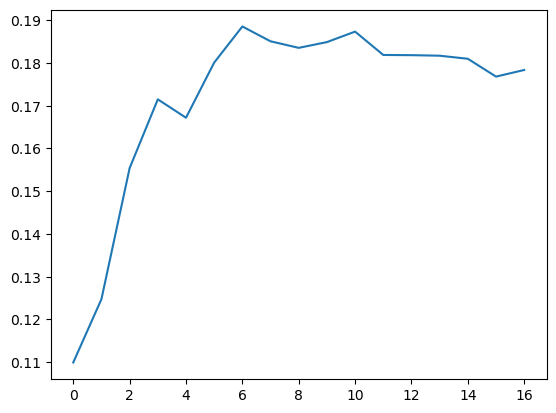

In [92]:
# I think I know what's happening since depth increases at greater setbacks
# so the larger setbacks open up deeper incised channels but the calculation I have set up
# doesn't necessarily use the channel minimum I don't think
d_chan = np.nanmean(d_all[:,:,str_setbacks[0]==1], axis=2)
pd.DataFrame(d_chan).loc[0].plot()

<Axes: >

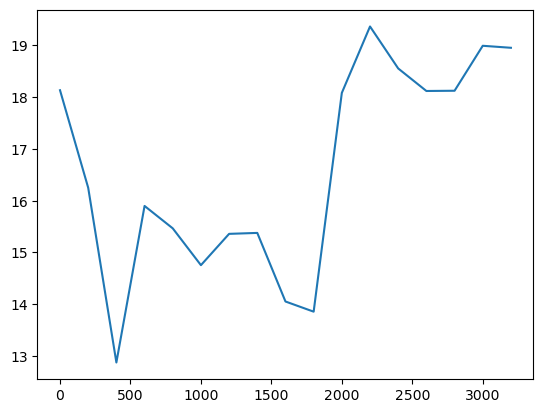

In [78]:
# not clear why the recharge at the channel increases in some cases with setback distance when it should really only decrease as flood depth
# should always decrease with increasing setback

# the complexity is that we are summing the recharge in the channel for the whole domain
# and the depth in the channel is interpolated upstream and dependent on flow
# 
rch_chan_all[rch_chan_all.ft==2].drop(columns=['ft']).transpose().loc[6].plot()#.boxplot()
# need to plot depth for an individual realization to check the dynamics are what we expect

In [ ]:
from matplotlib import cm
#normalize item number values to colormap
cmap = cm.viridis
# norm = mpl.colors.Normalize(vmin=0, vmax=len(setbacks)) # continuous
bounds = np.arange(0, len(setbacks)+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N) # discrete

def plt_downstream_median(Q_all, ft_in, ax,  sec=False):
    T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
    p_l_in = flood_type.loc[ft_in,'pk_loc']
    tp_in = int(p_l_in*T_in)
    # plot segments in reverse order to align with idea that upstream is east and downstream is west
    Q_plt = pd.DataFrame(np.median(Q_all[:,tp_in,:], axis=0), columns = np.arange(28*2, -2, -2)).transpose()
    # for t in np.arange(0,len(setbacks)):
    #     Q_plt.iloc[:,t].plot(legend=False, ax=ax, color=cm.gray(norm(t)),alpha=0.7,)
    Q_plt.plot(legend=False, ax=ax, color=cm.viridis(norm(np.arange(0,len(setbacks)))), alpha=0.7,)
    if sec:
        def scale_Q(x):
            return ((x / Q_plt.values[0,0])-1)*-1
        def unscale_Q(x):
            return ((x*-1+1) * Q_plt.values[0,0])
        ax.secondary_yaxis('right', functions=(scale_Q, unscale_Q))

    return(Q_plt)

In [ ]:
## we want to show the depths in the channel to explain fish passage capabilities
## but also depth on the floodplain for supporting fish juvenile rearing and other floodplain processes
ft_in=2
f = h5py.File(join(data_dir,'hdf5', 'peak_flow_xs_depth_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
d_xs_all = f['array']['all'][:]
f.close()
# for s in np.arange(0,16):
# the min, max, and mean should be taken across the segments then averaged across realizations
    # d_mean = d_xs_all[:,tp_in, s, :-1].mean(axis=1).median()
    # d_min = d_xs_all[:,tp_in, s, :-1].min(axis=1).median()
    # d_max = d_xs_all[:,tp_in, s, :-1].max(axis=1).median()

In [ ]:
# plt.plot(np.transpose(np.median(d_xs_all[:, tp_in, :, :-1], axis=0)));

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
smid = 8
setbacks_lgd = [
    Line2D([0], [0],color='black',label='Seback 600 m', linestyle='--'),
    Line2D([0], [0],color='black',label='Seback 1200 m', linestyle='-.'),
]


In [ ]:

fig,ax=plt.subplots(3,2, sharex=True, sharey=False, figsize=(6.5, 6.5), dpi=600)
ax[0,0].set_title('Peak Flow ($m^3/s$) - left\n Fractional Reduction - right')
ax[0,1].set_title('Floodplain depth (m)')
region='regional'
s = [3,6]
ls = ['--','-.']
for nf, ft_in in enumerate(ft_plt):
    f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    Q_all = f['array']['all'][:]
    f.close()
    ax_d = ax[nf, 0]
    Q_plt = plt_downstream_median(Q_all, ft_in, ax=ax_d, sec=True)
    Q_plt[s].plot(ax=ax_d, legend=False, color='black', style=ls,linewidth=0.5, alpha=0.7)

    # f = h5py.File(join(data_dir,'hdf5', 'depth_avg_arr'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    # d_all = f['array']['all'][:]
    # f.close()
    ax_n = ax[nf,1]
    ax_n.yaxis.set_label_position("right")
    ax_n.yaxis.tick_right()
    # xs_fld_df, xs_fld_dpth, xs_rch = plt_xs_dpth(d_all, rch_hf_all, ax_n)
    xs_fld_df = xs_fld_df_all[xs_fld_df_all.ft==ft_in].drop(columns=['ft'])
    xs_fld_df.plot(ax=ax_n, legend=False, color=cm.viridis(norm(np.arange(0,len(setbacks)))), alpha=0.7)
    # xs_fld_df.plot(ax=ax_n, legend=False, color=cm.viridis(norm(np.arange(0,len(setbacks)))), alpha=0.7)
    xs_fld_df[s].plot(ax=ax_n, legend=False, color='black', style=ls, linewidth=0.5, alpha=0.7)

lgd = fig.legend(handles=setbacks_lgd,  loc='center left', bbox_to_anchor=(0.2, 1.02),ncol=3)
ax[-1,0].set_xlabel('Upstream distance (km)')
ax[-1,1].set_xlabel('Upstream distance (km)')
xtick = np.sort(xs_fld_df.index.values)[::2]
ax[-1,0].set_xticks(ticks=xtick,labels=xtick, rotation=45)
ax[-1,1].set_xticks(ticks=xtick,labels=xtick, rotation=45)
# fig.supxlabel('Upstream distance (km)')
fig.tight_layout(h_pad=0 ) #pad=0.4, w_pad=0.5,

cbar_ax=ax.ravel().tolist()

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=cbar_ax, 
                    # ticks=bounds[:-1]+0.5, 
                    label='Seback distance (m)',
                    orientation='horizontal', ticks=bounds[:-1:2]+0.5, 
                   )
cbar.set_ticklabels(setbacks[::2]);


# Depth maps

In [ ]:
grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')


In [ ]:
s=16
setback = s*200
# sfr line
sfr_union = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_sfr.unary_union], crs=grid_sfr.crs)
sfr_union.geometry = sfr_union.buffer(setback).exterior
# grid limits
setback_grid = gpd.sjoin(sfr_union, grid_p, how='left')
setback_outer = np.zeros((nrow,ncol))
setback_outer[setback_grid.row-1, setback_grid.column-1] = 1
setback_outer = ma.masked_where(setback_outer==0,setback_outer)

Try to use a logarithmic scale on the inundation depth. Really blow up the dimensions of the second figure (or increase DPI to 500) to improve the detail in those figures. I would also add a stream and a buffer boundary.

In [ ]:
fig,ax=plt.subplots(3,1, sharex=True, sharey=False, figsize=(8,6),dpi=600)
vmin, vmax = (10,0 )
region='regional'
for nf, ft_in in enumerate(ft_plt):
    ax_n = ax[nf]
    im = ax_n.imshow(d_arr[nf], 
#                      vmin = np.nanmin(d_arr), vmax = np.nanmax(d_arr), 
                     norm = mpl.colors.LogNorm(vmin = 1E-2, vmax = np.nanmax(d_arr)),
                     zorder=1
                    )
#     im = ax_n.imshow(rch_arr[nf], vmin = np.min(rch_arr), vmax = np.max(rch_arr))
    ax[nf].imshow(setback_outer, cmap='gray') # works when dpi=600
#         ax[nf].scatter(setback_grid.column-1, setback_grid.row-1, facecolor='black', edgecolor='none', marker='.', s=5,
#                       zorder=10)
    ax[nf].plot(grid_sfr.column-1, grid_sfr.row-1, color='black', linewidth=0.5, linestyle='-.')
#         ax[nf].plot(up_gdf.column-1, up_gdf.row-1, color='black', )
    


fig.tight_layout(h_pad=-.5) #pad=0.4, w_pad=0.5,
cbar_ax=ax.ravel().tolist()
fig.colorbar(im, ax=cbar_ax, orientation='vertical', label='Depth (m)', shrink=0.4,location='right')
# fig.colorbar(im, ax=cbar_ax, orientation='horizontal', label='Depth (m)', shrink=0.4)


## Inundation area


In [ ]:
print('Flood depth')
xs_fld_df_lower = xs_fld_df_all[xs_fld_df_all.index.isin(np.arange(0,18))]
# mean depth for each floodplain reach and median depth across realizations
xs_fld_df_all.groupby('ft').mean()[[3,6, 9]]
xs_fld_df_lower.groupby('ft').mean()[[3,6, 9]]




In [ ]:
cell_frac = np.zeros((3,len(setbacks), nrow,ncol))

for nf, ft_in in enumerate(ft_plt):
    f = h5py.File(join(data_dir,'hdf5', 'cell_frac_arr'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    cell_frac_all = f['array']['all'][:]
    f.close()
    # spatial view
    cell_frac_all = ma.masked_invalid(cell_frac_all)
    # median across realizations
    cell_frac[nf] = np.median(cell_frac_all, axis=0)

# mask where depth is 0
cell_frac = ma.masked_where(cell_frac==0, cell_frac)


In [ ]:
print('Fractional area')
for s in [3,6, 9]:
    # calculate fraction of inundated floodplain for median case
    # frac_sum = np.nansum(cell_frac[:, s], axis=(1,2))/str_setbacks[s].sum()
    # subset to lower third
    frac_sum = np.nansum(cell_frac[:, s, :, :rch_col], axis=(1,2))/str_setbacks[s].sum()
    print(s, frac_sum.round(4))

In [ ]:
# np.nanmean(cell_frac)

In [ ]:
# (cell_frac>1).sum()*100/(100*230*3)


In [ ]:
# fig,ax = plt.subplots(dpi=600)
# im=ax.imshow(cell_frac[0])
# plt.colorbar(im, shrink=0.5)
# # cell_frac[0]

# Summary statistics/relationships

The geology is interesting because it enables us to show that across a variety of aquifer compositions there is consistency in the value of recharge with setback distance because it is driven by the mean lengths, but we aren't quantifying that because we have constant mean lengths.  

One item that would be helpful is if we could make an equation to relate the expected recharge to the number of facies given a discharge? We should compare the correlation or R2 value on recharge from geology vs the flood flow to identify under which conditions the geology or flow is more limited as these relationships can be specific to a setback.

- for a given setback calculate the correlation coefficient between the geologic area and the recharge. A relationship of mean flow or flow area and recharge won't work because we can only use the inflow since downstream flows are impact by the geology and we only have 3 flood types.

\* *We need to use mean flow rather than depth because flow is conservative while depth is segment dependent. The depth is more important when considering ecological thresholds*

In [ ]:
# statistics functions
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import datasets, linear_model
from scipy.stats import pearsonr, spearmanr, kendalltau


While the summary stats are a way to mark when the system is geology vs flow limited this doesn't directly help policy makers beyond suggesting limits based on flow limitation. For policy makers we want to suggest solutions that they can make based on the status of their system of geology/flow. How does setback distance change in a system with low to moderate to high outcroppings of coarse facie?
- If a system has more coarse deposits then is a smaller setback more attainable? 

- Pearson's r absolute value: .5 to 1 is strong, .3 to .5 is moderate, 0 to .3 is weak
    - italicize r, no leading zero as maximum is 1, two significant digits is common, if reporting significance of the test then also report degrees of freedom (sample size - 2)   
- Spearman's coefficient is defined as the Pearson coefficient between the rank variables. X, Y are converted to ranks R(X), R(Y) then pearson's r is calculated.
- Kendall's tau is a test on whether the order of the variables aligns with the values, that is xi > xj and yi > yj to be considered concordant. The statistics then is based on the number of concordant and discordant pairs.

In [ ]:
percentile = 6
label='regional'
hf_tot_df = pd.read_csv(data_dir+'surface_highflow_by_distance_'+label+'_'+str(percentile)+'.csv')
# hf_tot_df = hf_tot_df.transpose()
hf_tot_df.columns = hf_tot_df.columns.astype(int)

In [ ]:
ft_in=3
rch_corr = rch_xs_all[rch_xs_all.ft==ft_in].drop(columns=['ft']).transpose().copy()
# rch_corr = rch_lower[rch_lower.ft==ft_in].drop(columns=['ft']).transpose().copy()
# rch_corr = rch_scale_sum.copy()


In [ ]:
def reg_plt(x, y, ax):
    ax.scatter(x,y)
    # linear, regression
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    x_range = np.array([[x.min()], [x.max()]])
    ax.plot(x_range, regr.predict(x_range), color='black', linewidth=3)
    r2_val = r2_score(y, regr.predict(x))
    ax.annotate('$r^2$: '+ str(np.round(r2_val,3)), (0.4,0.1), xycoords='axes fraction')
    
# fig,ax = plt.subplots()
# s = 200
# reg_plt(hf_tot_df[[s]].values, rch_corr[[s]].values, ax=ax)

In [ ]:
# analysis is across the realizations

fig, ax = plt.subplots(4,4, figsize=(6.5,6.5), sharex='row', sharey='row')
for n, s in enumerate(setbacks[:-1]):
    ax_n = ax[int(n/4), n%4]
    x = hf_tot_df[[s]].values
    y = rch_corr[[s]].values
    reg_plt(x, y, ax=ax_n)
fig.supylabel('Recharge (MCM)')
fig.supxlabel('Number of HCP cells')
fig.tight_layout()

In [ ]:

ft_in=1 
xs_fld_df = xs_fld_df_all[xs_fld_df_all.ft==ft_in].drop(columns=['ft'])
xs_rch_df = xs_rch_df_all[xs_rch_df_all.ft==ft_in].drop(columns=['ft'])

fig, ax = plt.subplots(4,4, figsize=(10,10), sharex=False, sharey=False)
for ns, s in enumerate(setbacks[:-1]):
    ax_n = ax[int(ns/4), ns%4]
    # compare across segments for relationship
    x = xs_fld_df[[ns]].values
    y = xs_rch_df[[ns]].values
    reg_plt(x, y, ax=ax_n)
fig.supylabel('Recharge (MCM)')
fig.supxlabel('Flood Depth')
fig.tight_layout()

The linear regression helps demonstrate that the geology has a decreasing impact at higher setback distances because there is more control from the discharge loss rather than the geology. Since the linear fit is so weak it might actually be interesting to see if there is a non-signficant correlation between recharge and number of HCP cells after a certain setback.

In [ ]:
tests = ['Pearson', 'Spearman','Kendall']
def calc_corr_stats(corr_all, coarse_ref):
    # take pearson's r
    pr = corr_all.apply(lambda x : pearsonr(coarse_ref, x), axis=0)
    pr.index=['r','p']
    pr['type'] = 'Pearson'
    sr = corr_all.apply(lambda x : spearmanr(coarse_ref, x), axis=0)
    sr.index=['r','p']
    sr['type'] = 'Spearman'
    kt = corr_all.apply(lambda x : kendalltau(coarse_ref, x), axis=0)
    kt.index=['r','p']
    kt['type'] = 'Kendall'
    # join data together
    corr_out = pd.concat((pr, sr, kt))
    return(corr_out)
# corr_out = calc_corr_stats(corr_all, coarse_ref.num_coarse)

In [ ]:
# hf_tot_df[[s]].values
setbacks

In [ ]:
# calc_corr_stats(hf_tot_df[[s]], setbacks).assign(setback=s)

In [ ]:
corr_out = pd.DataFrame()
for s in setbacks:
    corr = calc_corr_stats(rch_corr[[s]], hf_tot_df[s]).assign(setback=s)
    corr = corr.rename(columns={s:'val'})
                  
    corr_out = pd.concat((corr_out, corr), axis=0)

# fig, ax = plt.subplots(4,4, figsize=(6.5,6.5), sharex='row', sharey='row')
# for n, s in enumerate(setbacks[:-1]):
#     ax_n = ax[int(n/4), n%4]
    # corr_plt = corr_out[corr_out.setback==s].loc['r'].set_index('type').transpose()
corr_plt = corr_out.loc['r'].pivot_table(index='setback', values='val',  columns='type', dropna=False)
corr_plt[tests].plot(kind='bar', rot=25)
    # corr_plt.plot(kind='bar', ax=ax_n, rot=25)

The correlation plots present the same information as the linear regression that we see a lower strength of relationship between geology and recharge with greater setback distances. These low correlation coefficients are likely driven by the large areas of the domain that are above floodplain access which means the HCP area is meaningless, so it might be necessary to check this result on a localized level (variability of HCP area by XS group).

Beyond the impact of geology, Helen was interested in the general relationship between depth/inundated area and recharge which also requires plotting by XS

# Summary tables

In [ ]:
ft_in = 2

T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
p_l_in = flood_type.loc[ft_in,'pk_loc']
tp_in = int(p_l_in*T_in)
# for each setback distance and flood type
# prsent discharge at the downstream end (avg over realizations and use peak flow)
q_avg = Q_all[:,tp_in,s,-1].mean().round(1)
q_std = Q_all[:,tp_in,s,-1].std().round(1)
q_out = str(q_avg)+'±'+ str(q_std)

In [ ]:
def format_mean(df):
    df_avg = df.mean().round(1)
    df_std = df.std().round(1)
#     df_out = str(df_avg)+'±'+ str(df_std)
    df_out = str(df_avg)+'\u00B1'+ str(df_std)
    return(df_out)


In [ ]:
# ft_in=1
# f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
# rch_hf_all = f['array']['all'][:]
# f.close()

In [ ]:

# s=2
# # present mean total recharge and std dev
# rch_sum = rch_hf_all[:,s].sum(axis=(1,2))/1E6
# format_mean(rch_sum)

With the +- symbol saving to csv file causes an issue with utf-8 encoding of the csv and adds a symbol. Saving it as a text file doesn't cause an issue and the data can then be pasted into an xlsx to format for the paper. The txt file also writes the fastest.  
The flow differencing has same standard deviation as discharge because it comes from the same data, and it only shows the inverse.  
Flow depth can be back calculated with the discharge saved. Depth might not be a good parameter to plot because there is a big range in cross-section type, although the key reason for depth is to suggest if flow is to shallow rather than too deep so perhaps presenting mean and minimum depth is best.

In [ ]:
# format_mean(d_all[:2])

In [ ]:
f_csv = open(join(fig_dir, 'summary_table.txt'), 'w', encoding="utf-8")
region='regional'

for nf, ft_in in enumerate(ft_plt):
#     for nr, region in enumerate(['local_1','local_2','local_3','regional']):
#     max_df = max_df_all.loc[(max_df_all.region==region)&(max_df_all.ft==ft_in),'count']
#     max_s = max_df.argmax()
    f = h5py.File(join(data_dir,'hdf5', 'all_flow_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    Q_all = f['array']['all'][:]
    f.close()
    # recharge
    f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    rch_hf_all = f['array']['all'][:]
    f.close()
    f = h5py.File(join(data_dir,'hdf5', 'peak_flow_xs_depth_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
    d_xs_all = f['array']['all'][:]
    f.close()
    T_in = int(10**flood_type.loc[ft_in,'log_no_d'])
    p_l_in = flood_type.loc[ft_in,'pk_loc']
    tp_in = int(p_l_in*T_in)
#     Q_s = Q_all[:,tp_in, max_s,:].mean(axis=0)
#     d_Q_s = Q_s[0]-Q_s[-1]
    ## output cleaning ##
    for s in np.arange(0,len(setbacks)):
    #     rch_mean =  rch_mean_all.loc[(rch_mean_all.region==region)&(rch_mean_all.ft==ft_in),'mean']
        q_out = format_mean(Q_all[:,tp_in,s,-1])
        rch_out = format_mean(rch_hf_all[:,s].sum(axis=(1,2))/1E6)
#         d = d_all[:,tp_in, s, :-1]
#         d_out = str(d.mean().round(2))+' ('+ str(d.min().round(2))+'-'+ str(d.max().round(2))+')'
        # the min, max, and mean should be taken across the segments then averaged across realizations
        d_mean = d_xs_all[:,tp_in, s, :-1].mean(axis=1).mean()
        d_min = d_xs_all[:,tp_in, s, :-1].min(axis=1).mean()
        d_max = d_xs_all[:,tp_in, s, :-1].max(axis=1).mean()
        d_out = str(d_mean.round(2))+' ('+ str(d_min.round(2))+'-'+ str(d_max.round(2))+')'
        # summarize optimal setback distance with mean recharge and mean flow reduction
        out = ','.join([flood_type.loc[ft_in,'Typology'],
              str(setbacks[s]),  rch_out,
          q_out, d_out, '\n'])
        f_csv.write(out)
#         print( flood_type.loc[ft_in,'Typology'], region_names[nr],
#               setbacks[max_s], '%.0f' %rch_mean.iloc[max_s],'%.0f' %d_Q_s)

f_csv.close()

In [ ]:
for s in np.arange(0,len(setbacks)):

    d_mean = d_xs_all[:,tp_in, s, :-1].mean(axis=1).mean()
    d_min = d_xs_all[:,tp_in, s, :-1].min(axis=1).mean()
    d_max = d_xs_all[:,tp_in, s, :-1].max(axis=1).mean()
    print('Mean %.2f'%d_mean,'min %.2f'%d_min,'max %.2f'%d_max)